In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_context('paper', font_scale=2)    


In [93]:
def add_n(ax, data, feature):
    total = data[feature].sum()
    ylim = ax.get_ylim()[1]
    for p in ax.patches:
        percentage = '{:,.0f}'.format(p.get_height())
        x_scale = 0.034*len(percentage)
        x = p.get_x() + p.get_width() / 2 - x_scale
        y = p.get_y() + p.get_height() + ylim*0.01
        ax.annotate(percentage, (x, y), size = 12)

In [36]:
def get_talon_nov_colors(samples=None):
    c_dict = {'Known': '#009E73',
              'ISM': '#0072B2',
              'NIC': '#D55E00',
              'NNC': '#E69F00',
              'Antisense': '#000000',
              'Intergenic': '#CC79A7',
              'Genomic': '#F0E442'}
    order = ['Known', 'ISM', 'NIC', 'NNC', 'Antisense', 'Intergenic', 'Genomic']
    if samples:
        keys = c_dict.keys()
        pop_list = []
        for key in keys:
            if key not in samples:
                pop_list.append(key)
        for p in pop_list:
            del c_dict[p]
        order = [o for o in order if o in samples]   
    return c_dict, order

In [40]:
def compute_prop_support(sj_file, ab_file, opref):
    sj_df = pd.read_csv(sj_file, sep='\t')
    ab = pd.read_csv(ab_file, sep='\t')  
    
    # merge with ab to get novelty info
    ab = ab[['annot_transcript_id', 'transcript_novelty']]
    sj_df = sj_df.merge(ab, how='left', left_on='tid', right_on='annot_transcript_id')    
    
    # count up splice junctions per transcript
    sjs_per_t = sj_df[['tid', 'sj_id']].groupby('tid').count()
    sjs_per_t.reset_index(inplace=True)
    sjs_per_t.rename({'sj_id':'total_sjs'}, axis=1, inplace=True)
    
    # groupby transcript id and illumina support
    sj_df = sj_df[['tid', 'transcript_novelty', 'illumina_support', 'sj_id']].groupby(['tid', 'transcript_novelty', 'illumina_support']).count()
    sj_df.reset_index(inplace=True)
    sj_df.rename({'sj_id':'n_sjs'}, axis=1, inplace=True)
    
    # merge with total sjs and calc % supported
    sj_df = sj_df.merge(sjs_per_t, how='left', on='tid')
    sj_df['perc_supported'] = (sj_df.n_sjs/sj_df.total_sjs)*100
    
    # remove unsupported bois
    sj_df = sj_df.loc[sj_df.illumina_support == True]

    # drop antisense, intergenic, and genomic cause they bad
    novs = ['Known', 'ISM', 'NIC', 'NNC']
    sj_df = sj_df.loc[sj_df.transcript_novelty.isin(novs)]
    
    # plot plot
    c_dict, order = get_talon_nov_colors(novs)
    ax = sns.violinplot(data=sj_df, x='transcript_novelty', y='perc_supported', order=order, palette=c_dict, saturation=1, linewidth=0.5)
    ax.set_ylabel('% SJs in transcript supported by Illumina')
    ax.set_xlabel('Isoform Novelty')
    fname = '{}_illumina_sj_support.pdf'.format(opref)
    plt.savefig(fname)
    
    # average and median of each category
    for n in novs: 
        temp = sj_df.loc[sj_df.transcript_novelty==n]
        print()
        print('Mean % Illumina supported SJs for {}: {}'.format(n, temp.perc_supported.mean()))
        print('Median % Illumina supported SJs for {}: {}'.format(n, temp.perc_supported.median()))    

In [94]:
def plot_unsupp_sjs_by_nov(sj_file, sj_nov_file, oprefix):
    sj_df = pd.read_csv(sj_file, sep='\t')
    nov_df = pd.read_csv(sj_nov_file, sep='\t', header=None, 
        usecols=[0,1,2,3,9], names=['chrom', 'start', 'stop', 'strand', 'novelty'])
    
    nov_df['sj_id'] = nov_df.chrom+'_'+nov_df.start.astype(str)+'_'+nov_df.stop.astype(str)+'_'+nov_df.strand.astype(str)
    nov_df = nov_df[['sj_id', 'novelty']]
    
    # limit to just sjs with no illumina support
    sj_df = sj_df.loc[sj_df.illumina_support == False]

    # merge with novelty of splice junctions
    sj_df = sj_df.merge(nov_df, how='left', on='sj_id')
    
    sj_df = sj_df[['sj_id', 'novelty']]
    sj_df.drop_duplicates(inplace=True)

    # groupby and count # of Illumina-supported SJs per SJ novelty category
    sj_df = sj_df.groupby('novelty').count()
    sj_df.reset_index(inplace=True)
    sj_df.rename({'sj_id':'sj_count'}, axis=1, inplace=True)
    
    # plot plot
    c_dict, order = get_talon_nov_colors(['Known', 'NIC', 'NNC'])
    ax = sns.barplot(data=sj_df, x='novelty', y='sj_count', palette=c_dict, hue_order=order, saturation=1)
    ax.set_ylabel('Number of SJs unsupported by Illumina')
    ax.set_xlabel('SJ Novelty')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    add_n(ax, sj_df, 'sj_count')
    
    fname = '{}_ill_unsupported_sj_novelty.pdf'.format(oprefix)
    plt.savefig(fname)

## PacBio


Mean % Illumina supported SJs for Known: 96.49993710385937
Median % Illumina supported SJs for Known: 100.0

Mean % Illumina supported SJs for ISM: 99.5236694953262
Median % Illumina supported SJs for ISM: 100.0

Mean % Illumina supported SJs for NIC: 98.11438401683239
Median % Illumina supported SJs for NIC: 100.0

Mean % Illumina supported SJs for NNC: 93.48281695577082
Median % Illumina supported SJs for NNC: 100.0


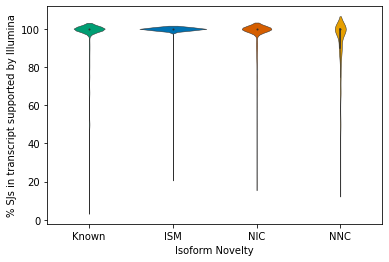

In [41]:
sj_file = 'pb_GM12878_sj_tid_support.tsv'
ab_file = 'pb_ont_talon_abundance_filtered.tsv'

compute_prop_support(sj_file, ab_file, 'PB_GM12878')

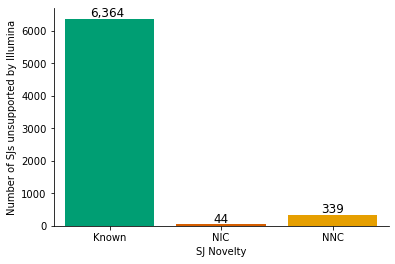

In [95]:
sj_file = 'pb_GM12878_sj_tid_support.tsv'
sj_nov_file = 'pb_talon_GM12878_sjs_novelty.tab'

plot_unsupp_sjs_by_nov(sj_file, sj_nov_file, 'figures/PB_GM12878')

## ONT


Mean % Illumina supported SJs for Known: 94.39099416715977
Median % Illumina supported SJs for Known: 100.0

Mean % Illumina supported SJs for ISM: 96.67296784336611
Median % Illumina supported SJs for ISM: 100.0

Mean % Illumina supported SJs for NIC: 82.87438998469071
Median % Illumina supported SJs for NIC: 85.71428571428571

Mean % Illumina supported SJs for NNC: 81.26478960319763
Median % Illumina supported SJs for NNC: 83.33333333333334


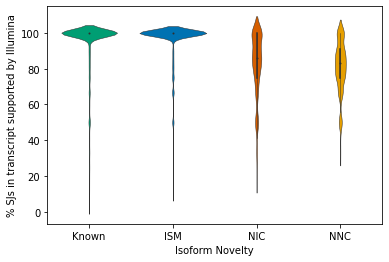

In [96]:
sj_file = 'ont_GM12878_sj_tid_support.tsv'
ab_file = 'pb_ont_talon_abundance_filtered.tsv'

compute_prop_support(sj_file, ab_file, 'figures/ONT_GM12878')

In [ ]:
sj_file = 'ont_GM12878_sj_tid_support.tsv'
sj_nov_file = 'ont_talon_GM12878_sjs_novelty.tab'

plot_unsupp_sjs_by_nov(sj_file, sj_nov_file, 'figures/PB_GM12878')